# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for `d9`

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [3]:
# get the corresponding dataframe1
train_data_d9 <- train_data_original$d9

In [4]:
## create the corresponding task as for dataframe 1
tsks_train_d9 <- TaskSurv$new("df9", backend = train_data_original$d9, time = "time", event = "status")
## check the task
tsks_train_d9

<TaskSurv:df9> (834 x 10)
* Target: time, status
* Properties: -
* Features (8):
  - int (8): V1, V2, V3, V4, V5, V6, V7, V8

## Hyperparameter Tuning for `d9`


#### Step 1: Boosting with the AFT model

Step 1_1: Try with a default setting

In [5]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d9,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [02:19:20.281] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:19:20.447] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 2/3) 
INFO  [02:19:21.177] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 3/3) 
INFO  [02:19:21.767] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 1/3) 
INFO  [02:19:22.597] [mlr3]  Finished benchmark 


In [6]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.574

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5628db3d6070>,df9,surv.mboost,cv,3,0.5735129


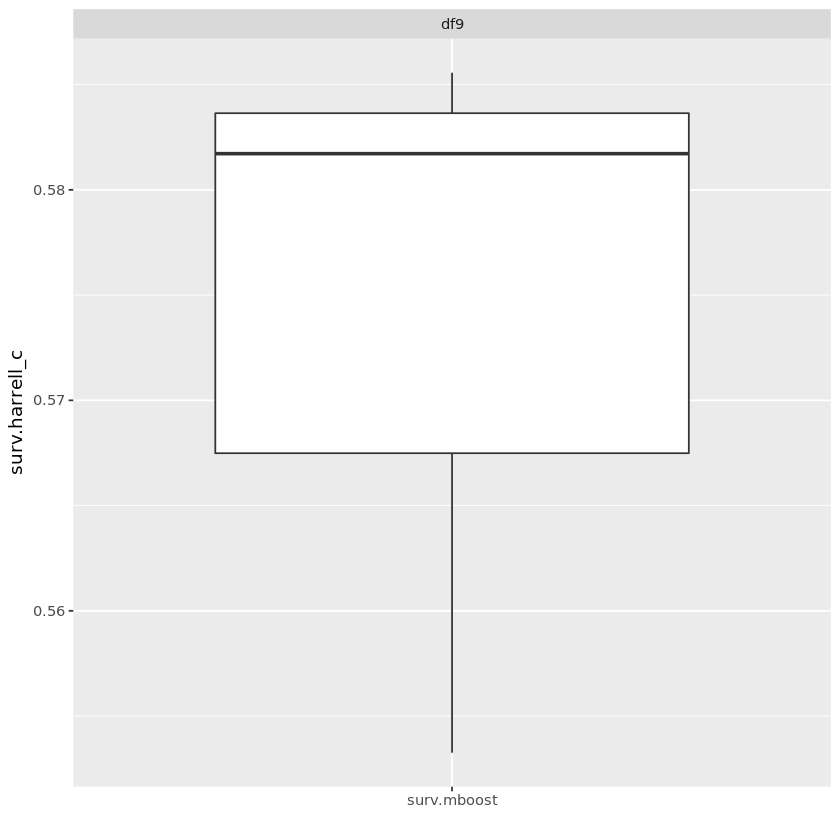

In [7]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [9]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d9, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [02:23:47.166] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df9' (iter 2/3) 
INFO  [02:23:47.204] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [02:23:47.209] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:23:47.238] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:23:47.248] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 1/3) 
INFO  [02:23:53.119] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 3/3) 
INFO  [02:23:58.858] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 2/3) 
INFO  [02:24:04.791] [mlr3]  Finished benchmark 
INFO  [02:24:04.849] [bbotk] Result of batch 1: 
INFO  [02:24:04.852] [bbotk]  baselearner    family mstop  nu surv.harrell_c 
INFO  [02:24:04.852] [bbotk]        btree lognormal   300 0.5      0.5675797 
INFO  [02:24:04.852] [bbotk]                                 uhash 
INFO  [02:24:04.852] [bbotk]  5269f0f0-ebd1-4fcd-b2b6-039d6a4bc708 

In [10]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.575

surv.harrell_c 
     0.5746739

In [11]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "loglog"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 175

[[1]]$nu
[1] 0.1625

Step 1_3: Autoplot the pre and after tuning boxplots

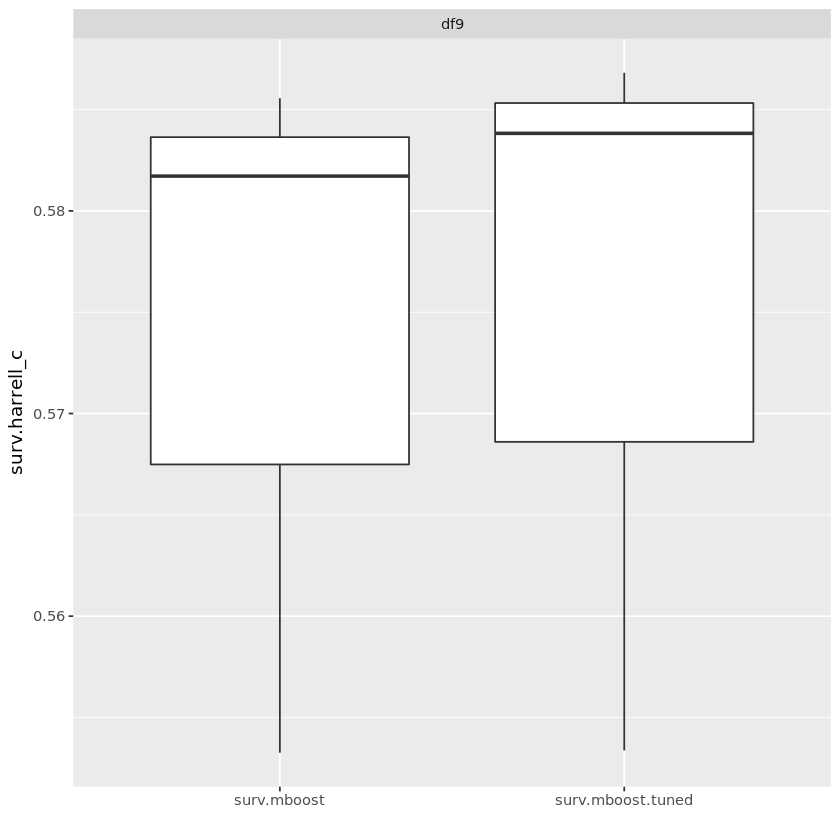

In [12]:
# autoplot the two boxplots
autoplot(c(aft_bmr, aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [13]:
design <- benchmark_grid(
  tasks = tsks_train_d9,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [02:30:00.389] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:30:00.397] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 2/3) 
INFO  [02:30:02.893] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 3/3) 
INFO  [02:30:05.534] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 1/3) 
INFO  [02:30:07.884] [mlr3]  Finished benchmark 


In [14]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.560

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5628dbc58888>,df9,surv.mboost,cv,3,0.559998


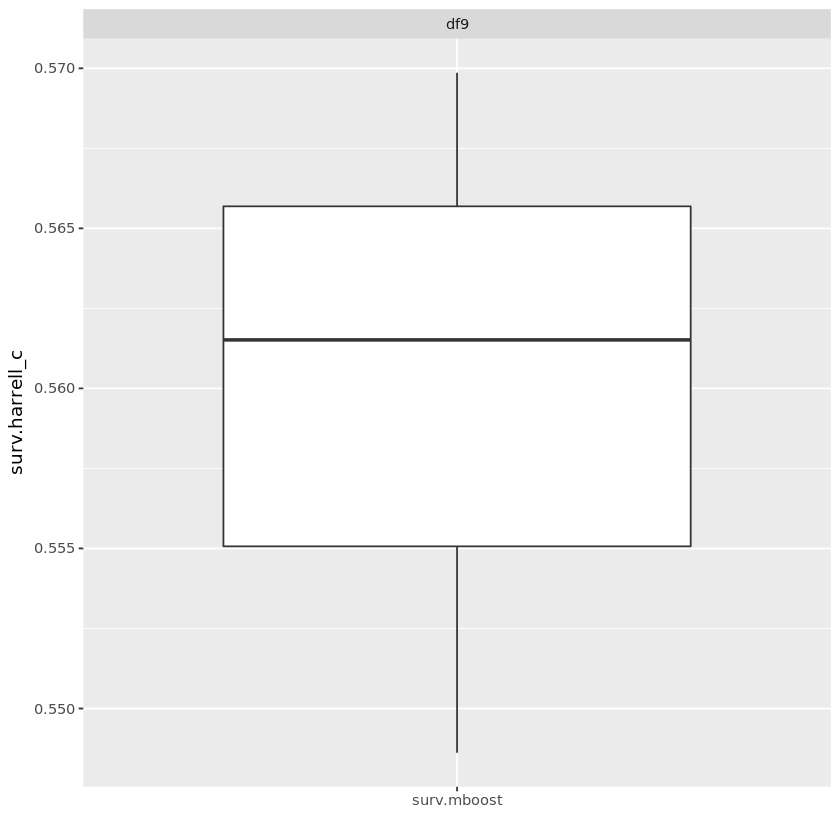

In [15]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [16]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d9, grid_auto_mb, outer_rsmp, store_models = TRUE)


INFO  [02:30:44.359] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df9' (iter 1/2) 
INFO  [02:30:44.393] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [02:30:44.397] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:30:44.424] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [02:30:44.434] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 1/2) 
INFO  [02:30:48.398] [mlr3]  Applying learner 'surv.mboost' on task 'df9' (iter 2/2) 
INFO  [02:30:51.776] [mlr3]  Finished benchmark 
INFO  [02:30:51.820] [bbotk] Result of batch 1: 
INFO  [02:30:51.823] [bbotk]  baselearner family mstop  nu surv.harrell_c 
INFO  [02:30:51.823] [bbotk]        btree cindex   133 0.1      0.5379747 
INFO  [02:30:51.823] [bbotk]                                 uhash 
INFO  [02:30:51.823] [bbotk]  f3ccc65b-78ed-4570-959b-bec434bffec2 
INFO  [02:30:51.825] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:30:51.850] [mlr3]  Be

In [17]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.570

surv.harrell_c 
     0.5698301

In [18]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "coxph"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 50

[[1]]$nu
[1] 0.1

Step 2_3: Autoplot the pre and after tuning boxplots

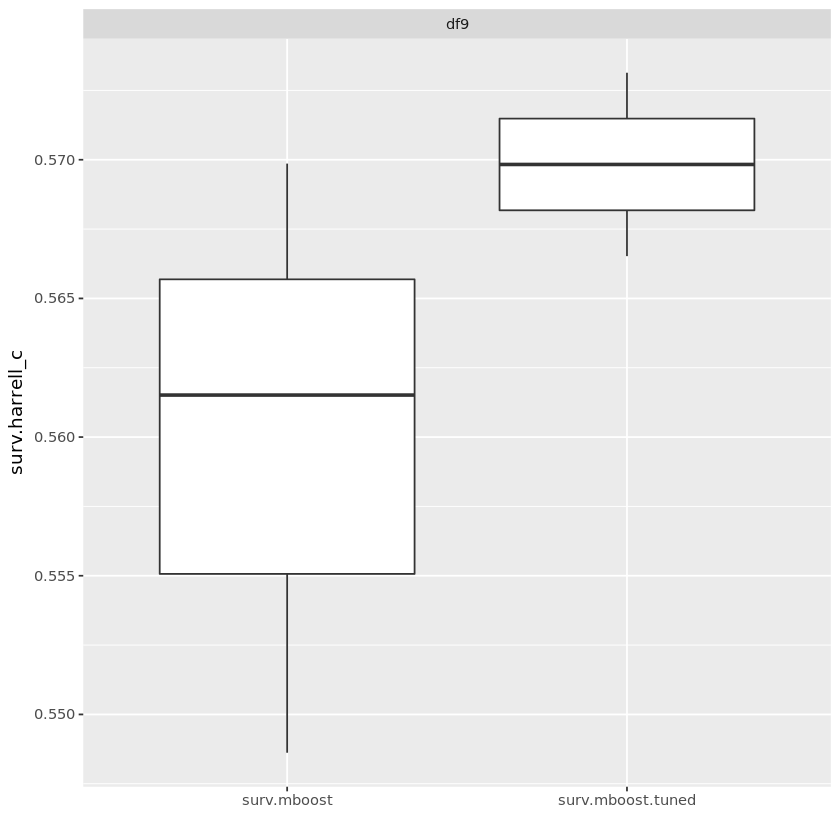

In [19]:
# autoplot the two boxplots
autoplot(c(mb_bmr, mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [20]:
# check the task
tsks_train_d9 # no need

<TaskSurv:df9> (834 x 10)
* Target: time, status
* Properties: -
* Features (8):
  - int (8): V1, V2, V3, V4, V5, V6, V7, V8

Step 3_2: Try with a default setting

In [21]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [22]:
install_learners('surv.coxboost')

In [23]:
design <- benchmark_grid(
  tasks = tsks_train_d9,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

cb_results <- cb_bmr$aggregate(measures = all_measures)
cb_results # 0.574

INFO  [02:39:26.748] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [02:39:26.757] [mlr3]  Applying learner 'surv.coxboost' on task 'df9' (iter 2/3) 
INFO  [02:39:30.151] [mlr3]  Applying learner 'surv.coxboost' on task 'df9' (iter 3/3) 
INFO  [02:39:33.938] [mlr3]  Applying learner 'surv.coxboost' on task 'df9' (iter 1/3) 
INFO  [02:39:37.082] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5628fadb8440>,df9,surv.coxboost,cv,3,0.5738725


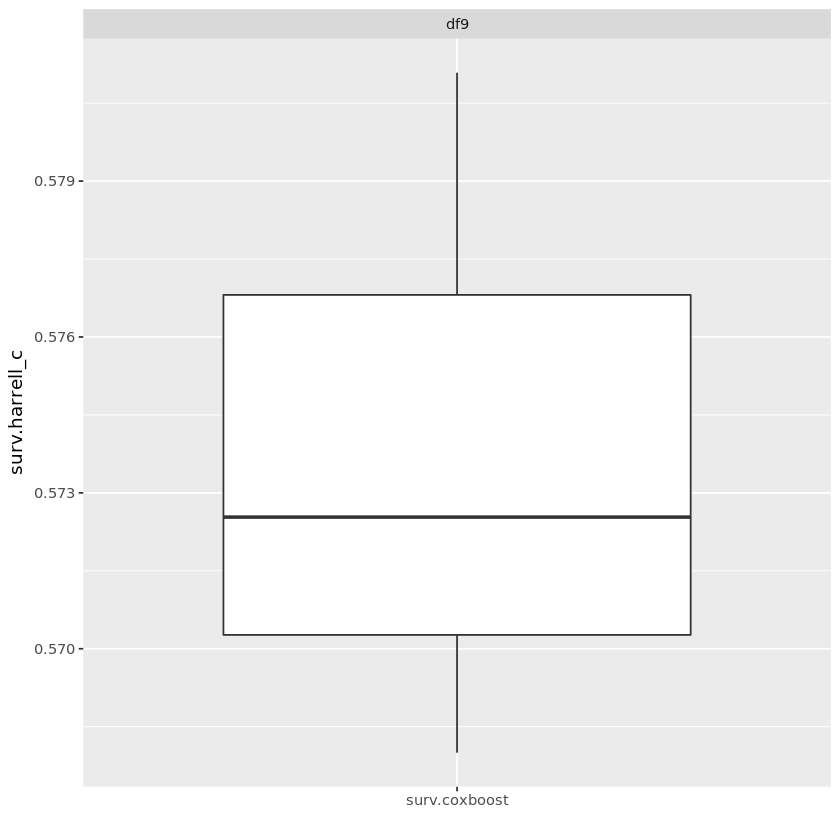

In [24]:
# plot the corresponding the performance
autoplot(cb_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [25]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 250),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)

cb_bmr_2 = resample(tsks_train_d9, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [02:41:40.634] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df9' (iter 1/2) 
INFO  [02:41:40.668] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [02:41:40.673] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:41:40.699] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [02:41:40.708] [mlr3]  Applying learner 'surv.coxboost' on task 'df9' (iter 2/2) 
INFO  [02:41:43.370] [mlr3]  Applying learner 'surv.coxboost' on task 'df9' (iter 1/2) 
INFO  [02:41:46.059] [mlr3]  Finished benchmark 
INFO  [02:41:46.104] [bbotk] Result of batch 1: 
INFO  [02:41:46.107] [bbotk]  stepno  penalty stepsize.factor surv.harrell_c 
INFO  [02:41:46.107] [bbotk]     206 455.5556             4.5      0.5808398 
INFO  [02:41:46.107] [bbotk]                                 uhash 
INFO  [02:41:46.107] [bbotk]  ae454fac-7be1-4346-99c6-25c1f6e21f4c 
INFO  [02:41:46.109] [bbotk] Evaluating 1 configuration(s) 
INFO  [02:41:46.135

In [26]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.5733

surv.harrell_c 
     0.5733109

In [27]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 50

[[1]]$penalty
[1] 366.6667

[[1]]$stepsize.factor
[1] 4.5

Step_3_4: Autoplot the pre and after tuning boxplots

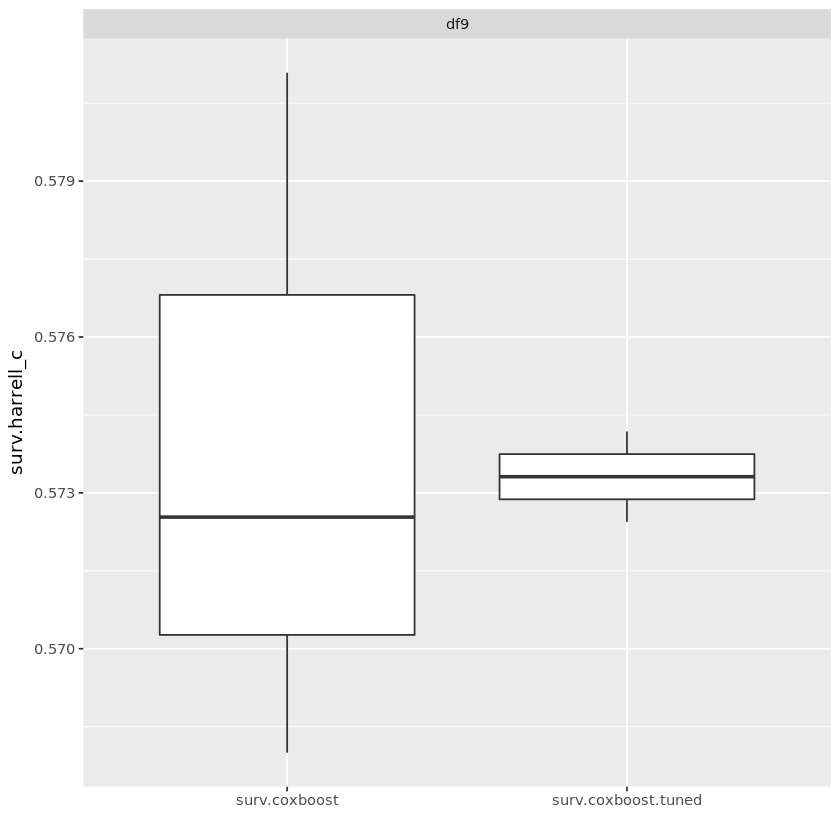

In [28]:
# autoplot the two boxplots
autoplot(c(cb_bmr, cb_bmr_2))